# In this notebook code for image preprocessing, raining and testing(image by image and overall accuracy) of UE4 image will be developed

In [2]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 19 # change it with respect to the desired class
IMG_SIZE = 48 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1
from keras.applications import VGG16

In [3]:
h5py.__version__

'2.9.0'

# Image preprocessing function

In [24]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1) # this lin is doing the channel fisrt operation

    return img

def get_class(img_path):
#     print((img_path.split('/')))
#     print(int(img_path.split('/')[-2]))
#     print(str(img_path.split('/')[-2]))
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [7]:
imgs = []
labels = []
root_dir = "/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/"
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*'))

In [8]:
all_img_paths[50000:50010]

['/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/67_SM_DenkMitEdelstahlReinigerSpray_20_66_90_60_lit_cropped.png',
 '/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/2322_SM_DenkMitEdelstahlReinigerSpray_20_161_30_60_lit_cropped.png',
 '/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/3062_SM_DenkMitEdelstahlReinigerSpray_20_181_10_60_lit_cropped.png',
 '/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/1587_SM_DenkMitEdelstahlReinigerSpray_20_146_50_60_lit_cropped.png',
 '/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/2943_SM_DenkMitEdelstahlReinigerSpray_20_62_10_60_lit_cropped.png',
 '/home/atif/machine_learning_stuff/ml_image/train_image_classification_better_resolution/crop/00006/329_SM_DenkMitEdelstahlReinigerSpray_20_328_90_60_lit

In [9]:
 #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1200 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 1200/61560
Processed 2400/61560
Processed 3600/61560
Processed 4800/61560
Processed 6000/61560
Processed 7200/61560
Processed 8400/61560
Processed 9600/61560
Processed 10800/61560
Processed 12000/61560
Processed 13200/61560
Processed 14400/61560
Processed 15600/61560
Processed 16800/61560
Processed 18000/61560
Processed 19200/61560
Processed 20400/61560
Processed 21600/61560
Processed 22800/61560
Processed 24000/61560
Processed 25200/61560
Processed 26400/61560
Processed 27600/61560
Processed 28800/61560
Processed 30000/61560
Processed 31200/61560
Processed 32400/61560
Processed 33600/61560
Processed 34800/61560
Processed 36000/61560
Processed 37200/61560
Processed 38400/61560
Processed 39600/61560
Processed 40800/61560
Processed 42000/61560
Processed 43200/61560
Processed 44400/61560
Processed 45600/61560
Processed 46800/61560
Processed 48000/61560
Processed 49200/61560
Processed 50400/61560
Processed 51600/61560
Processed 52800/61560
Processed 54000/61560
Processed 55200/61

In [10]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (61560, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (61560, 19)  type:  <class 'numpy.ndarray'>


# Model declaration

In [11]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
# def cnn_model():
#     model = Sequential()

#     model.add(Conv2D(64, (3, 3), padding='same',
#                      input_shape=(3, IMG_SIZE, IMG_SIZE),
#                      activation='relu'))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
    
#     model.add(Conv2D(256, (3, 3), padding='same',
#                      input_shape=(3, IMG_SIZE, IMG_SIZE),
#                      activation='relu'))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(1024, (3, 3), padding='same',
#                      activation='relu'))
#     model.add(Conv2D(1024, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

#     model.add(Conv2D(2048, (3, 3), padding='same',
#                      activation='relu'))
#     model.add(Conv2D(2048, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(NUM_CLASSES, activation='softmax'))
#     return model

# model = cnn_model()

# lr = 0.01
# sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#           optimizer=sgd,
#           metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 46, 46)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 23, 23)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 21, 21)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 10, 10)       0         
__________

In [14]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [15]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print("current time:", current_time)

current time: 2019-10-29 23:09:54


In [16]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 50
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+str(current_time)+'_new_image_OLD_PROCESS_model_epoch_'+str(epochs)+'.h5', save_best_only=True)])

Train on 49248 samples, validate on 12312 samples
Epoch 1/50
 - 43s - loss: 2.2062 - acc: 0.2521 - val_loss: 0.9322 - val_acc: 0.6377
Epoch 2/50
 - 42s - loss: 0.5755 - acc: 0.7789 - val_loss: 0.3389 - val_acc: 0.8648
Epoch 3/50
 - 42s - loss: 0.2766 - acc: 0.8922 - val_loss: 0.1668 - val_acc: 0.9315
Epoch 4/50
 - 42s - loss: 0.1779 - acc: 0.9329 - val_loss: 0.1299 - val_acc: 0.9456
Epoch 5/50
 - 43s - loss: 0.1296 - acc: 0.9525 - val_loss: 0.0717 - val_acc: 0.9764
Epoch 6/50
 - 43s - loss: 0.0977 - acc: 0.9658 - val_loss: 0.0529 - val_acc: 0.9785
Epoch 7/50
 - 43s - loss: 0.0798 - acc: 0.9723 - val_loss: 0.0782 - val_acc: 0.9774
Epoch 8/50
 - 43s - loss: 0.0597 - acc: 0.9804 - val_loss: 0.0323 - val_acc: 0.9901
Epoch 9/50
 - 43s - loss: 0.0563 - acc: 0.9823 - val_loss: 0.0391 - val_acc: 0.9882
Epoch 10/50
 - 43s - loss: 0.0409 - acc: 0.9863 - val_loss: 0.0095 - val_acc: 0.9966
Epoch 11/50
 - 43s - loss: 0.0060 - acc: 0.9985 - val_loss: 0.0018 - val_acc: 0.9996
Epoch 12/50
 - 43s - los

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


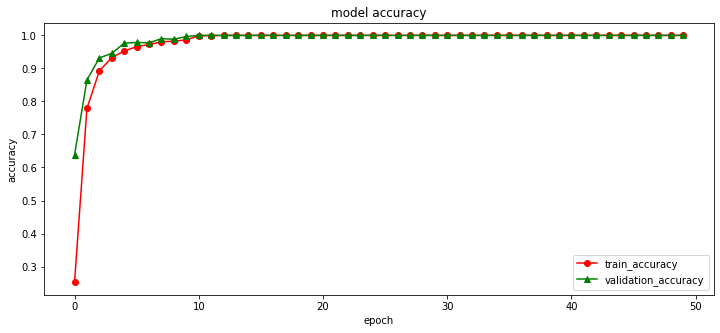

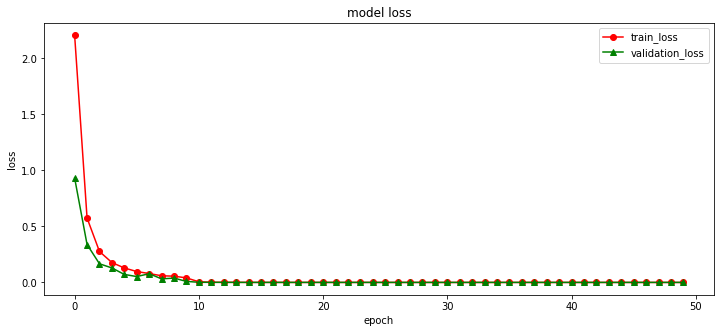

In [18]:
print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['acc'], '-o', color = 'red')
plt.plot(do_train_model.history['val_acc'],'-^', color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
# plt.savefig(path+str(current_time)+'_epoch_vs_accuracy.jpg')
# plt.show()

plt.figure()


print(do_train_model.history.keys())
# summarize history for accuracy
plt.plot(do_train_model.history['loss'],'-o', color = 'red')
plt.plot(do_train_model.history['val_loss'],'-^', color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='best')
# plt.savefig(path+str(current_time)+'_epoch_vs_loss.jpg')
plt.rcParams['figure.figsize'] =(12,5)
plt.show()

# load saved model

In [19]:
from keras.models import load_model
# model = load_model('/home/atif/machine_learning_stuff/model_file_keras/general_2_sep_ep_30_epoch.h5')
model = load_model(path+'2019-10-29 23:09:54_new_image_OLD_PROCESS_model_epoch_50.h5')

# Check total accuracy of the model using all test images

In [25]:
import pandas as pd
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_file_same_number.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  calgonit_finish_speizalsalz (3).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (1).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (2).jpg 	 classId:  3
filename:  calgonit_finish_speizalsalz (4).jpg 	 classId:  3
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  34_SM_DenkMitEdelstahlReinigerSpray_20_33_90_60_lit_cropped.jpg 	 classId:  6
filename:  denkmit_edelsthal_reiniger_spray.jpg 	 classId:  6
filename:  real_DenkMitEdelstahlReinigerSpray_right1.jpg 	 classId:  6
filename:  real_DenkMitEdelstahlReinigerSpray_right4.jpg 	 classId:  6
filename:  somat_3.jpg 	 classId:  17
filename:  somat_6.jpg 	 classId:  17
filename:  somat_7.jpg 	 classId:  17
filename:  somat_8.jpg 	 classId:  17
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_E

In [26]:
print(img_path)

/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/385_SM_SomatExtraAllIn1_56_24_80_60_lit_cropped.png


In [27]:
y_test

array([ 3,  3,  3,  3,  5,  5,  5,  5,  6,  6,  6,  6, 17, 17, 17, 17,  7,
        7,  7,  7, 12, 12, 12, 12, 13, 13, 13, 13,  1,  1,  1,  1,  0,  0,
        0,  0, 11, 11, 11, 11,  8,  8,  8,  8, 14, 14, 14, 14,  9,  9,  9,
        9,  4,  4,  4,  4,  2,  2,  2,  2, 10, 10, 10, 10, 15, 15, 15, 15,
       16, 16, 16, 16, 18, 18, 18, 18])

# finding accuracy

In [28]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.013157894736842105


In [29]:
y_pred

array([16, 16,  9, 13, 14, 16, 14, 14, 16, 11,  9, 14,  9,  9,  9,  9,  9,
        9,  9,  9, 16, 16, 13, 14, 14,  9, 11, 13, 16, 16, 16, 10, 14, 14,
       14, 14,  9,  9,  9,  9, 14, 14, 14, 14, 13, 13, 13, 13, 14, 16, 14,
       14, 14, 14,  9, 14, 16,  3, 16, 14, 14,  9, 14, 16,  9, 14, 16, 14,
        9, 14,  9, 13, 16,  9,  3, 17])

# check true vs true/false result

In [30]:
count =0
right_count=0
wrong_count=0
for i,j in enumerate(y_test):
    count +=1
    if j == y_pred[i]:
        right_count+=1
#         print(count,'-'*5,j,'-'*5,y_pred[i])
        
    else:
#         pass
        wrong_count+=1
        print(count,'°'*40,j,'-'*5,y_pred[i])
print('total: ',count)
print('right_count: ',right_count)
print('wrong_count',wrong_count)

1 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 3 ----- 16
2 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 3 ----- 16
3 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 3 ----- 9
4 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 3 ----- 13
5 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 14
6 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 16
7 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 14
8 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 14
9 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 6 ----- 16
10 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 6 ----- 11
11 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 6 ----- 9
12 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 6 ----- 14
13 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 17 ----- 9
14 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 17 ----- 9
15 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 17 ----- 9
16 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 17 ----- 9
17 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 7 ----- 9
18 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 7 ----- 9
19 °°°°°°°°°°°°°°°°°°°°

# do accuracy calculationfrom scratch

In [31]:
accuracy = (right_count/y_pred.shape[0])*100
print(accuracy)

1.3157894736842104


# confusion matrix calculation

In [32]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0]]
<class 'numpy.ndarray'>
(19, 19)


# confusion matrix visualization with seaborn heatmap

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(19),
                  range(19))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(19)
figure = ax.get_figure()    
# figure.savefig('12_sep_general_new_model_no_augmentation_confusion.png', dpi=400)


# confusion matrix visualization with matplotlib

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Accent)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
# plt.xticks(y_pred)
plt.yticks([], [])
# plt.xticks(y_test)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# check class image by image

In [ ]:
import glob

test_image_path = r'/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'

my_name = ['SM_CalgonitFinish_2','SM_CalgonitFinishKlarspueler_5','SM_CalgonitFinishMaschinenpfleger_8','SM_CalgonitFinishSpezialSalz_11',
           'SM_CalgonitFinishVorratspack_14','SM_DenkMitEdelstahlreiniger_17','SM_DenkMitEdelstahlReinigerSpray_20','SM_DenkMitEntkalker_23',
           'SM_DenkMitGeschirrReiniger_26','SM_DenkMitGeschirrReinigerClassic_29','SM_DenkMitGeschirrReinigerEvo_32','SM_DenkMitGeschirrReinigerNature_35',
           'SM_DenkMitHygieneAllzweckreiniger_38','SM_DenkMitMaschinenpfleger_41','SM_DenkMitSpezialsalz_44','SM_SomatClassic_53']

img_path = glob.glob(test_image_path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),3,IMG_SIZE,IMG_SIZE)
    
    print('image name is: ',image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
#     print('type-of predicted calss: ', type(predicted_class))
    print('class name is: ',my_name[predicted_class[0]])
    
#     probability = model.predict_proba(X_test)
#     print("probability: ",probability)
    print('\n')

# training with data augmentation

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

In [ ]:
model_augmentation = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_augmentation.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [ ]:
nb_epoch = 50
batch_size = 32
model_augmentation.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint(path+str(current_time)+'_AUGMENTATION_'+str(epochs)+'.h5',save_best_only=True)]
                           )

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import matplotlib
matplotlib.__version__